In [1]:
### analysis
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from gsw import sigma0,t_freezing

### plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
# import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
# rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=29) 
rc('ytick', labelsize=29) 
rc('axes', labelsize=29)
from matplotlib.ticker import MultipleLocator

#### This notebook can be used to reproduce panels b-d of Figure 1, panel a does not contain analysis (excepting generating a climatological mean sea ice concentration simply from https://nsidc.org/data/g10033/versions/1) so is not reproduced here.

author: Ruth Moorman, April 2023, rmoorman@caltech.edu

## Data

For the generation of plots for Figure 1 we use 49 ship-borne profiles of potential temperature (converted to conservative temperature using TEOS10 functions), practical salinity (converted to absolute salinity using TEOS10 functions), dissolved oxygen, and potential density (computed from absolute salinity and conservative temperature using TEOS10 function) from 9 cruises (NBP0001, JR141, NBP0702, NBP0901, NBP1005, ANA02, ANA04, ANA06, ANA08) ranging from 2000 to 2018. These are all the shipborne profiles we were able to obtain in the domain of 114ºW-111ºW 74.3ºS-74.1ºS in front of the Dotson Ice Shelf, baring the exclusion of any profiles that purely sample the surface (deepest measurement < 200 db) or had obvious QC issues.

The source of raw observations from each cruise are as follows (as of Feb 2023):

NBP0001: data was not obtained from original cruise participants but extracted from Jenkins et al 2018 (https://www.usap-dc.org/view/dataset/601105)

JR141: data was not obtained from original cruise participants but extracted from Jenkins et al 2018 (https://www.usap-dc.org/view/dataset/601105) [*note: no dissolved oxygen data obtained*]

NBP0702: https://www.marine-geo.org/tools/search/entry.php?id=NBP0702#datasets

NBP0901: https://www.marine-geo.org/tools/entry/NBP0901 

NBP1005: https://www.marine-geo.org/tools/search/Files.php?data_set_uid=17186 

ANA02: https://kpdc.kopri.re.kr/search/50deac03-104e-4264-ad75-cafd4ca2f336 

ANA04: https://kpdc.kopri.re.kr/search/2c489f38-6e59-4b38-b208-12359f0d3579 

ANA06: https://kpdc.kopri.re.kr/search/0edae2a7-d680-47bc-84f6-233d26c1d3a6 

ANA08: https://kpdc.kopri.re.kr/search/f511e827-d898-4cde-8d89-fe9a7b373e55 

The collated and processed (using TEOS10 functions) data are provided in this repository and loaded below.

Note we do not have precise collection dates (only years) for data obtained from NBP0001 and JR141.


In [2]:
ds = xr.open_dataset('Dotson-Ice-Front-shipborne-profiles.nc')
ds

<xarray.Dataset>
Dimensions:              (NPROF: 49, pressure: 2000)
Coordinates:
  * NPROF                (NPROF) int64 63 64 65 66 67 ... 1052 1053 1054 1055
  * pressure             (pressure) int64 1 2 3 4 5 ... 1996 1997 1998 1999 2000
    lat                  (NPROF) float64 ...
    lon                  (NPROF) float64 ...
    time                 (NPROF) datetime64[ns] ...
    cruise               (NPROF) object ...
    cruise_index         (NPROF) float64 ...
    deepest_measurement  (NPROF) float64 ...
Data variables:
    CT                   (NPROF, pressure) float64 ...
    PT                   (NPROF, pressure) float64 ...
    AS                   (NPROF, pressure) float64 ...
    PSAL                 (NPROF, pressure) float64 ...
    DO                   (NPROF, pressure) float64 ...
    SIGMA0               (NPROF, pressure) float64 ...

# Figure 1 (b,c)

For Figure 1 (b) we sort temperature profiles in density bins, compute average temperature values in each density bin for each cruise, then map that mean profile back onto pressure using the cruise mean density profile. This is following the procedure described in Dutrieux et al (2014). We also apply a slight smoothing (5 dbar interval) so the thermocline is more obvious.

For Figure 1 (c) we repeat this procedure for salinity but skip dont map back to pressure levels, then the plot density binned mean temperature against the density binned mean salinity.

In [3]:
cruise_index    = np.array([0,1,2,4,5,6,7,9,10])
cruises_ordered = np.array(['NBP0001', 'JR141', 'NBP0702', 'NBP0901', 'NBP1005', 'ANA02', 'ANA04', 'ANA06', 'ANA08'])
years_ordered   = np.array([2000,2006,2007,2009,2011,2012,2014,2016,2018])
colors_ordered  = np.array(['red', 'g','limegreen','magenta', 'blueviolet', 'b','deepskyblue','olive', 'darkorange'])

In [4]:
CT = ds.CT; AS = ds.AS; SIGMA = ds.SIGMA0

In [5]:
# generate mean density profile for each cruise
SIGMA_cruise = ds.SIGMA0.groupby('cruise_index').mean('NPROF')
SIGMA_cruise = SIGMA_cruise.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})
# construct a non uniform pressure bin grid to determine mean density within
bins                 = np.arange(0, 1020,10)
pressure_bins_center = np.arange(5,1010,10)
SIGMA_pressure_bins  = SIGMA_cruise.groupby_bins('pressure', bins).mean()
SIGMA_pressure_bins.coords['pressure_bins'] = pressure_bins_center; SIGMA_pressure_bins = SIGMA_pressure_bins.rename({'pressure_bins': 'pressure'}) #renaming
SIGMA_pressure_bins = SIGMA_pressure_bins.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})
# construct density bins specific to each cruise from above
vmin=np.array([[0],[0],[0],[0],[0],[0],[0],[0], [0]]);vmax=vmin+30 # cap the sigma bins
SIGMA_bins = np.concatenate((vmin,(SIGMA_pressure_bins.values[:,:-1]+np.diff(SIGMA_pressure_bins.values[:,:],axis=1)/2), vmax),axis=1)
SIGMA_bins = np.sort(SIGMA_bins, axis=1)
SIGMA_bins = xr.DataArray( SIGMA_bins, coords=[cruise_index, np.arange(len(bins))], dims=['cruise_index', 'SIGMA_index'])


In [6]:
CT = CT.assign_coords({'SIGMA0':SIGMA});AS = AS.assign_coords({'SIGMA0':SIGMA})

In [7]:
def density_averaged_profiles(index, CT=CT, AS=AS, SIGMA_bins=SIGMA_bins, pressure_bins_center=pressure_bins_center):
    # temperature
    print(cruises_ordered[index])
    CT_subset = CT.where(CT.cruise_index==cruise_index[index], drop=True)
    CT_mean = CT_subset.groupby_bins('SIGMA0' , SIGMA_bins.sel(cruise_index=cruise_index[index]).values).mean()
    CT_std = CT_subset.groupby_bins('SIGMA0' , SIGMA_bins.sel(cruise_index=cruise_index[index]).values).std()
    CT_mean['SIGMA0_bins'] = pressure_bins_center; CT_mean = CT_mean.rename({'SIGMA0_bins': 'pressure_midpoint'})
    CT_std['SIGMA0_bins'] = pressure_bins_center; CT_std = CT_std.rename({'SIGMA0_bins': 'pressure_midpoint'})
    CT_mean = CT_mean.interpolate_na('pressure_midpoint');CT_std = CT_std.interpolate_na('pressure_midpoint')
    # salinity
    AS_subset = AS.where(AS.cruise_index==cruise_index[index], drop=True)
    AS_mean = AS_subset.groupby_bins('SIGMA0' , SIGMA_bins.sel(cruise_index=cruise_index[index]).values).mean()
    AS_std = AS_subset.groupby_bins('SIGMA0' , SIGMA_bins.sel(cruise_index=cruise_index[index]).values).std()
    AS_mean['SIGMA0_bins'] = pressure_bins_center; AS_mean = AS_mean.rename({'SIGMA0_bins': 'pressure_midpoint'})
    AS_std['SIGMA0_bins'] = pressure_bins_center; AS_std = AS_std.rename({'SIGMA0_bins': 'pressure_midpoint'})
    AS_mean = AS_mean.interpolate_na('pressure_midpoint');AS_std = AS_std.interpolate_na('pressure_midpoint')    
    return CT_mean, CT_std,AS_mean, AS_std

In [8]:
CT_mean_2000,CT_std_2000, AS_mean_2000,AS_std_2000 = density_averaged_profiles(0,CT=CT, AS=AS)
CT_mean_2006,CT_std_2006, AS_mean_2006,AS_std_2006 = density_averaged_profiles(1,CT=CT, AS=AS)
CT_mean_2007,CT_std_2007, AS_mean_2007,AS_std_2007 = density_averaged_profiles(2,CT=CT, AS=AS)
CT_mean_2009,CT_std_2009, AS_mean_2009,AS_std_2009 = density_averaged_profiles(3,CT=CT, AS=AS)
CT_mean_2011,CT_std_2011, AS_mean_2011,AS_std_2011 = density_averaged_profiles(4,CT=CT, AS=AS)
CT_mean_2012,CT_std_2012, AS_mean_2012,AS_std_2012 = density_averaged_profiles(5,CT=CT, AS=AS)
CT_mean_2014,CT_std_2014, AS_mean_2014,AS_std_2014 = density_averaged_profiles(6,CT=CT, AS=AS)
CT_mean_2016,CT_std_2016, AS_mean_2016,AS_std_2016 = density_averaged_profiles(7,CT=CT, AS=AS)
CT_mean_2018,CT_std_2018, AS_mean_2018,AS_std_2018 = density_averaged_profiles(8,CT=CT, AS=AS)
# compile into arrays for ease of organisation
CT_mean = xr.DataArray(np.stack((CT_mean_2000,CT_mean_2006, CT_mean_2007,CT_mean_2009,CT_mean_2011,CT_mean_2012,CT_mean_2014,CT_mean_2016,CT_mean_2018)), coords=[cruise_index,CT_mean_2000.pressure_midpoint], dims=['cruise_index', 'pressure_midpoint'])
CT_mean = CT_mean.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})
AS_mean = xr.DataArray(np.stack((AS_mean_2000,AS_mean_2006, AS_mean_2007,AS_mean_2009,AS_mean_2011,AS_mean_2012,AS_mean_2014,AS_mean_2016,AS_mean_2018)), coords=[cruise_index,AS_mean_2000.pressure_midpoint], dims=['cruise_index', 'pressure_midpoint'])
AS_mean = AS_mean.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})
CT_std = xr.DataArray(np.stack((CT_std_2000,CT_std_2006, CT_std_2007,CT_std_2009,CT_std_2011,CT_std_2012,CT_std_2014,CT_std_2016,CT_std_2018)), coords=[cruise_index,CT_std_2000.pressure_midpoint], dims=['cruise_index', 'pressure_midpoint'])
CT_std = CT_std.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})
AS_std = xr.DataArray(np.stack((AS_std_2000,AS_std_2006, AS_std_2007,AS_std_2009,AS_std_2011,AS_std_2012,AS_std_2014,AS_std_2016,AS_std_2018)), coords=[cruise_index,AS_std_2000.pressure_midpoint], dims=['cruise_index', 'pressure_midpoint'])
AS_std = AS_std.assign_coords({'cruise': xr.DataArray(cruises_ordered, coords=[cruise_index], dims=['cruise_index']),'year': xr.DataArray(years_ordered, coords=[cruise_index], dims=['cruise_index']),'color': xr.DataArray(colors_ordered, coords=[cruise_index], dims=['cruise_index']),})

NBP0001
JR141
NBP0702
NBP0901
NBP1005
ANA02
ANA04
ANA06
ANA08


## plot panels b and c (alongside legend)
note: water mass identification added manually

In [9]:
cruise_index    = np.array([0,1,2,4,5,6,7,9,10])
cruises_ordered = np.array(['NBP0001', 'JR141', 'NBP0702', 'NBP0901', 'NBP1005', 'ANA02', 'ANA04', 'ANA06', 'ANA08'])
years_ordered   = np.array([2000,2006,2007,2009,2011,2012,2014,2016,2018])
colors_ordered  = np.array(['red', 'g','limegreen','magenta', 'blueviolet', 'b','deepskyblue','olive', 'darkorange'])

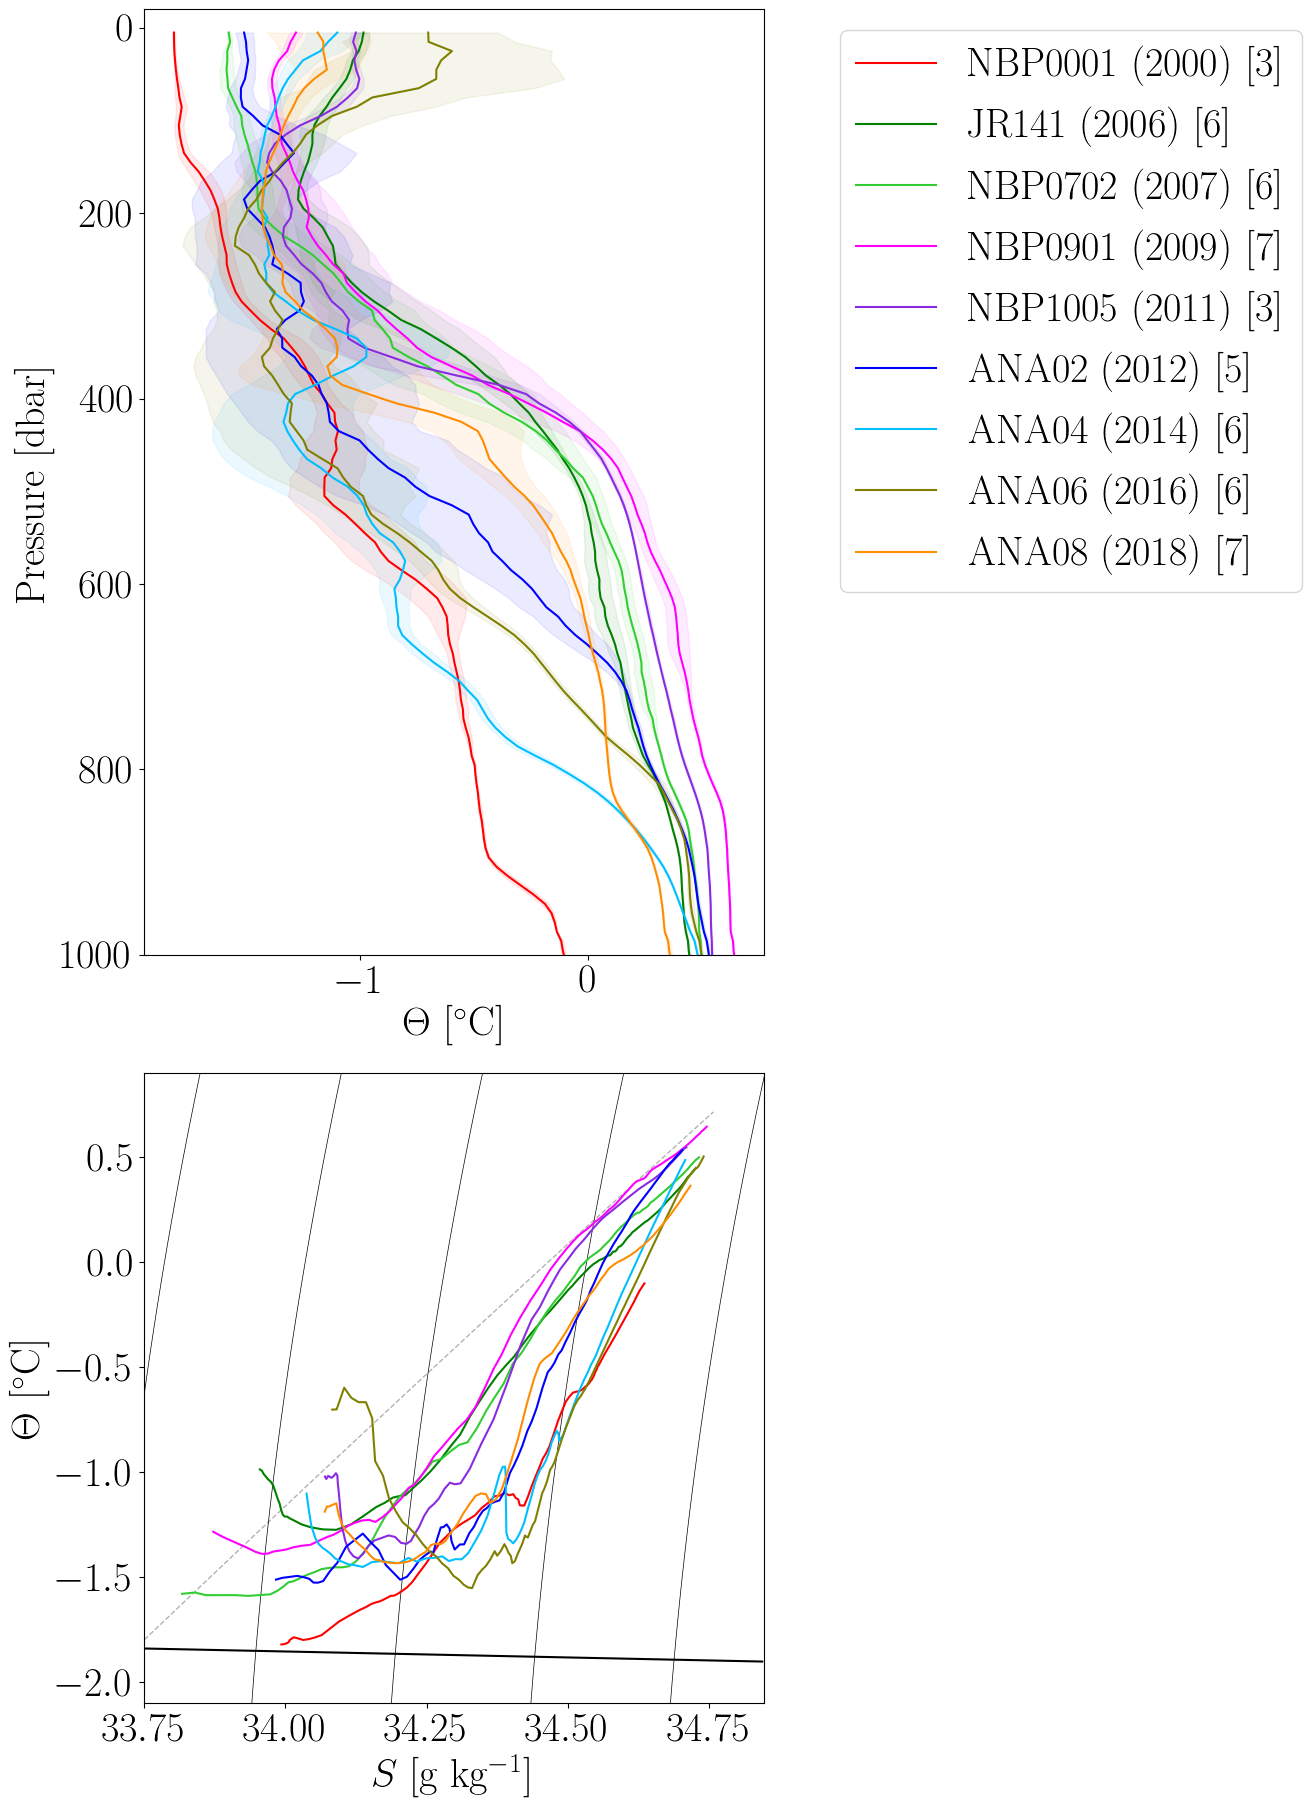

In [10]:
fig = plt.figure(figsize = (8,22))
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1.5,1])
ax,ax2 = (fig.add_subplot(gs[ 0]), fig.add_subplot(gs[1]))

Tarray = np.arange(-2.1,1,0.1)
Sarray = np.arange(33.75,34.85,0.0036)
Sgrid, Tgrid = np.meshgrid(Sarray, Tarray)
SIGMA0 = sigma0(Sgrid,Tgrid)
ax2.contour(Sgrid,Tgrid,SIGMA0, levels = [26.8,27,27.2,27.4,27.6,27.8,28], colors='k',linewidths=0.5)
Sarray = np.arange(Sgrid.min(),Sgrid.max(),0.0036);freezing_line = t_freezing(Sarray, 0,0)
ax2.plot(Sarray,freezing_line,'k', linewidth=1.5)
Sarray = np.arange(Sgrid.min(),34.76,0.0036);gade_line = 0.72+334/3.97*(1-34.76/Sarray)
ax2.plot(Sarray,gade_line,'k--', linewidth=1,alpha=0.3)

for i in range(0,len(CT_mean.cruise_index)):
    index=cruise_index[i]
    color = colors_ordered[i]
    cruise = cruises_ordered[i]
    year = str(years_ordered[i])
    profs = str(len(CT.where(CT.cruise_index==index,drop=True).NPROF))
    smoothed_CT = CT_mean.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    smoothed_CT_std = CT_std.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    smoothed_AS = AS_mean.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    ax.plot(smoothed_CT.T, CT_mean.pressure_midpoint, color=color, linewidth=1.5, label=cruise+' ('+year+') ['+profs+']')
    ax.fill_betweenx(CT_mean.pressure_midpoint,smoothed_CT-smoothed_CT_std,smoothed_CT+smoothed_CT_std, color=color,alpha=0.08 )
    ax2.plot(smoothed_AS.T, smoothed_CT.T, color=color, linewidth=1.5)

ax.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize=29)  
ax.set_ylim([1000,-20]);
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('$\Theta$ [$^\circ$C]')
ax2.set_xlabel('$S$ [g kg$^{-1}$]')
ax2.set_ylabel('$\Theta$ [$^\circ$C]')
plt.subplots_adjust(hspace=0.15)
# plt.savefig('Figure1_bc.png')
plt.show()

# Figure 1 (d)

## Stratification metric

Figure 1d in the main text presents timeseries of $\gamma$, a bulk indicator of stratification strength, instead of a more classic buoyancy frequency ($N^2$) based metric. While profiles of $N^2$ were useful in the motivating our work, it was difficult to quantify temporal patterns in $N^2$ due to the noisey nature of the signal. Precisely defining a depth range relevant to the thermocline at which $N^2$ could be extracted was difficult and $N^2$ metrics were sensitive to depth choices. The $\gamma$ metric metric gives a broader indication of the preconditioning of the water column as a whole.

Following Simpson et al (1978) and Venables and Meredith (2014), we define the stratification metric $\gamma$ as the potential energy of the water column relative to the potential energy of a mixed water column. This is effectively the energy input required to homogenize the water column to a given depth. Functionally this metric is defined as
\begin{equation}
 \gamma = \int_{h_2}^{h_1} (\rho-\langle \rho\rangle)gz\, dz \quad\textrm{where}\quad \langle\rho\rangle=\frac{1}{h_2-h_1}\int_{h_2}^{h_1}\rho\, dz.
 \end{equation}
We take $h_1$ to be a near surface point (here 5 m) and $h_2$ to be a depth deep enough to generally found below the thermocline yet shallow enough such that the deepest measurement from a large portion (here taken to be at least half) of the 49 profiles used exceed $h_2$ (here 750 m). For a vertically mixed column we have $\gamma=0$ with $\gamma$ growing increasingly positive for increasingly stable stratification. Only profiles with maximum depth exceeding $h_2$ are used in the calculation of $\gamma$, since the value of the integrated metric would be artificially reduced by missing values. At least 2 profiles meet this criterion for each cruise year and $h_2=750$ m. Figures 1d and the sensitivity figure below show the mean of $\gamma$ values calculated from each eligible profile in a given year, error bars show standard deviations of these values.
The temporal pattern of $\gamma$ is not altered by narrowing the integral bounds by 100 m from either side.

note readers can modify the depth cutoff and values of $h_1$ and $h_2$ to assess sensitivity to these choices.

In [11]:
h1 = 5; h2 = 750

In [12]:
ds_γ = ds.where(ds.deepest_measurement>h2,drop=True) # we will only use the subset of profiles with deepest measurment depper than 750 m (metric is sensitive to the total depth of profiles used so this must be kept constant) 

In [13]:
print('Original #profiles per cruise:')
print(ds.NPROF.groupby('cruise').count().values)
print(ds.NPROF.groupby('cruise').count().cruise.values)
print( )
print('#profiles per cruise with depth >h2:')
print(ds_γ.NPROF.groupby('cruise').count().values)
print(ds_γ.NPROF.groupby('cruise').count().cruise.values)
# so we only end up using 26 out of the 49 profiles, but >1 profiles are retained from each cruise

Original #profiles per cruise:
[5 6 6 7 6 3 6 7 3]
['ANA02' 'ANA04' 'ANA06' 'ANA08' 'JR141' 'NBP0001' 'NBP0702' 'NBP0901'
 'NBP1005']

#profiles per cruise with depth >h2:
[2 2 4 3 4 3 3 3 2]
['ANA02' 'ANA04' 'ANA06' 'ANA08' 'JR141' 'NBP0001' 'NBP0702' 'NBP0901'
 'NBP1005']


In [14]:
def gamma_func(ds, cruise, min_depth, max_depth):
    sigma0 = ds.where(ds.cruise==cruise,drop=True).SIGMA0
    sigma0 = sigma0.sel(pressure=slice(min_depth,max_depth))
    g = -9.81; z = -sigma0.pressure
    γ_mean = ((sigma0-sigma0.mean("pressure"))*g*z).sum("pressure").mean()
    γ_std = ((sigma0-sigma0.mean("pressure"))*g*z).sum("pressure").std()
    return γ_mean.values, γ_std.values

In [15]:
γ_timeseries = np.zeros(len(cruises_ordered))
γ_std_timeseries = np.zeros(len(cruises_ordered))
for i in range(len(cruises_ordered)):
    γ, γ_std = gamma_func(ds_γ, cruises_ordered[i], h1, h2)
    γ_timeseries[i] = γ
    γ_std_timeseries[i] = γ_std

In [16]:
γ_timeseries

array([207553.01478828, 260273.37564074, 255206.12563026, 254491.78226828,
       204995.84461234, 188111.38165011, 180588.11585662, 161727.8445485 ,
       194565.49545564])

In [17]:
γ_std_timeseries

array([ 9583.78606013,  4216.084837  , 17600.20308894,  1622.82867956,
       17566.64191792,  2021.79992975,  5538.7801773 , 15593.61449776,
        7663.43817902])

In [18]:
#test a couple of different bounds to push sensitivity of timeseries pattern
h1 = 105; h2 = 750

In [19]:
ds_γ = ds.where(ds.deepest_measurement>h2,drop=True) # we will only use the subset of profiles with deepest measurment depper than 750 m (metric is sensitive to the total depth of profiles used so this must be kept constant) 

In [20]:
γ_timeseries_alt = np.zeros(len(cruises_ordered))
γ_std_timeseries_alt = np.zeros(len(cruises_ordered))
for i in range(len(cruises_ordered)):
    γ, γ_std = gamma_func(ds_γ, cruises_ordered[i], h1, h2)
    γ_timeseries_alt[i] = γ
    γ_std_timeseries_alt[i] = γ_std

In [21]:
#test a couple of different bounds to push sensitivity of timeseries pattern
h1 = 5; h2 = 650

In [22]:
ds_γ = ds.where(ds.deepest_measurement>h2,drop=True) # we will only use the subset of profiles with deepest measurment depper than 750 m (metric is sensitive to the total depth of profiles used so this must be kept constant) 

In [23]:
γ_timeseries_alt2 = np.zeros(len(cruises_ordered))
γ_std_timeseries_alt2 = np.zeros(len(cruises_ordered))
for i in range(len(cruises_ordered)):
    γ, γ_std = gamma_func(ds_γ, cruises_ordered[i], h1, h2)
    γ_timeseries_alt2[i] = γ
    γ_std_timeseries_alt2[i] = γ_std

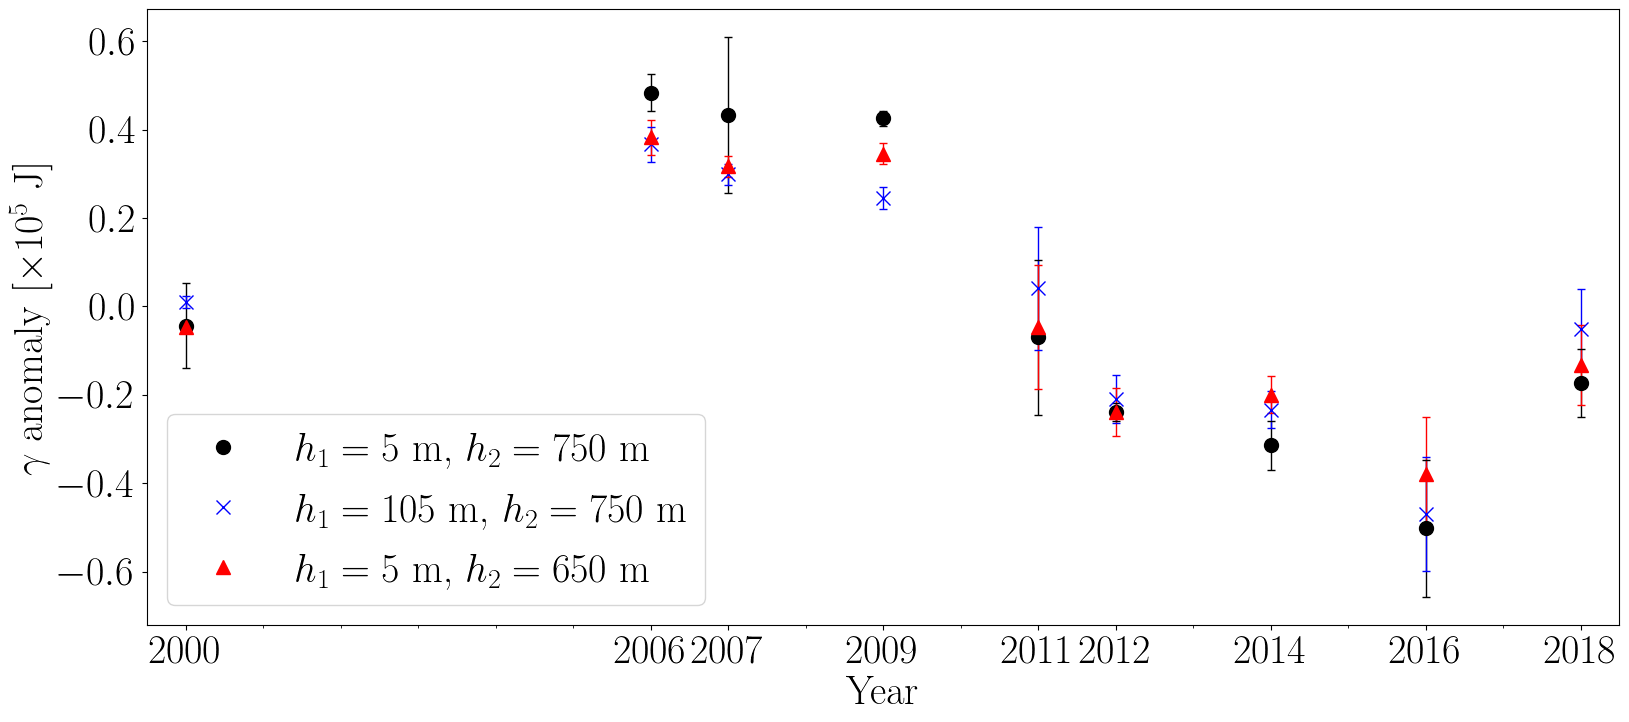

In [24]:
fig = plt.figure(figsize = (19,8))
ax = fig.add_subplot()
ax.errorbar(years_ordered, γ_timeseries/1e5-γ_timeseries.mean()/1e5, yerr = γ_std_timeseries/1e5, fmt='o', markersize=10,color='k', capsize=3, elinewidth=1, capthick=1)
ax.errorbar(years_ordered, γ_timeseries_alt/1e5-γ_timeseries_alt.mean()/1e5, yerr = γ_std_timeseries_alt/1e5, fmt='x', markersize=10,color='b', capsize=3, elinewidth=1, capthick=1)
ax.errorbar(years_ordered, γ_timeseries_alt2/1e5-γ_timeseries_alt2.mean()/1e5, yerr = γ_std_timeseries_alt/1e5, fmt='^', markersize=10,color='r', capsize=3, elinewidth=1, capthick=1)

ax.set_xticks(years_ordered)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel(r'$\gamma$ anomaly [$\times 10^5$ J]')
ln1 = ax.plot(1990, 0, 'ko', markersize=10,linewidth=0, label=r'$h_1 = 5$ m, $h_2 = 750$ m')
ln2 = ax.plot(1990, 0, 'bx', markersize=10,linewidth=0, label=r'$h_1 = 105$ m, $h_2 = 750$ m')
ln3 = ax.plot(1990, 0, 'r^', markersize=10,linewidth=0, label=r'$h_1 = 5$ m, $h_2 = 650$ m')
# ln2 = ax1.plot(1990, 200, 'kx',markersize=10, label=r'$\textrm{AD}_\textrm{mCDW}$ (thermocline depth metric)')
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3, fontsize=29)
ax.set_xlim([1999.5,2018.5])
ax.set_xlim([1999.5,2018.5])

plt.show()

## Thermocline depth metric


The Kim et al (2021) method requires that the following three equations should be satisfied simulateously,

$$\gamma^1_\mathrm{obs} = \gamma^1_\mathrm{MW}V_\mathrm{MW}+\gamma^1_\mathrm{WW}V_\mathrm{WW}+\gamma^1_\mathrm{mCDW}V_\mathrm{mCDW}$$

$$\gamma^2_\mathrm{obs} = \gamma^2_\mathrm{MW}V_\mathrm{MW}+\gamma^2_\mathrm{WW}V_\mathrm{WW}+\gamma^2_\mathrm{mCDW}V_\mathrm{mCDW}$$

$$V_\mathrm{MW}+V_\mathrm{WW}+V_\mathrm{mCDW} = 1$$

where $\gamma^1$ and $\gamma^2$ are either $\Theta$, $S$ or DO. They solve these expressions for the volume fractions as a function of the end member characteristics,

$$V_\mathrm{MW} = \frac{\big(\gamma^2_\mathrm{obs}-\gamma^2_\mathrm{mCDW}\big)-\big(\gamma^1_\mathrm{obs}-\gamma^1_\mathrm{mCDW}\big)\Big(\frac{\gamma^2_\mathrm{WW}-\gamma^2_\mathrm{mCDW}}{\gamma^1_\mathrm{WW}-\gamma^1_\mathrm{mCDW}}\Big)}
{\big(\gamma^2_\mathrm{MW}-\gamma^2_\mathrm{mCDW}\big)-\big(\gamma^1_\mathrm{MW}-\gamma^1_\mathrm{mCDW}\big)\Big(\frac{\gamma^2_\mathrm{WW}-\gamma^2_\mathrm{mCDW}}{\gamma^1_\mathrm{WW}-\gamma^1_\mathrm{mCDW}}\Big)}$$

$$V_\mathrm{WW} = \frac{\big(\gamma^1_\mathrm{obs}-\gamma^1_\mathrm{mCDW}\big)-\big(\gamma^1_\mathrm{MW}-\gamma^1_\mathrm{mCDW}\big)V_\mathrm{MW}}{\big(\gamma^1_\mathrm{WW}-\gamma^1_\mathrm{mCDW}\big)}$$

$$V_\mathrm{mCDW} = \frac{\big(\gamma^1_\mathrm{obs}-\gamma^1_\mathrm{WW}\big)-\big(\gamma^1_\mathrm{MW}-\gamma^1_\mathrm{WW}\big)V_\mathrm{MW}}{\big(\gamma^1_\mathrm{mCDW}-\gamma^1_\mathrm{WW}\big)}.$$

They compute the volume fraction vector using the three possible combinations of tracers ($\Theta$-$S$, $\Theta-$DO, $S-$DO) and then average the estimates to obtain a combined estimate.

Then in order to obtain an estimate of the absolute thickness of the mCDW layer we intergrate $V_\textrm{mCDW}$ between the bottom of the profile and 200 m (surface excluded due to higher uncertainties),

$$\textrm{AT}_\textrm{mCDW} = \int_\textrm{bottom}^{200 \textrm{m}} V_\textrm{mCDW}\,dz$$

and obtain an absolute depth (needed since profiles are of different depths) by removing this values from the profile depth

$$\textrm{AD}_\textrm{mCDW} = d-\textrm{AT}_\textrm{mCDW}.$$

**note: unfortunately we do not have DO data for JR141 (2006) so that will need to be excluded from this)**

In order to compute these volume fractions, we need to choose end member water mass characteristics.

Kim et al (2021) choose,

$$\Theta_\textrm{mCDW} = \textrm{temperature of the warmest waters}$$
$$S_\textrm{mCDW} = \textrm{salinity of the most saline waters}$$
$$DO_\textrm{mCDW} = \textrm{oxygen of the least oxygenated waters}$$

$$\Theta_\textrm{MW} = -95^\circ\textrm{ C}$$
$$S_\textrm{MW} = 0\textrm{ PSU}$$
$$DO_\textrm{MW} = 24.5\textrm{mL kg}^{-1} = 1065.4 \mu \textrm{mol L}^{-1}$$

$$\Theta_\textrm{WW} = \textrm{take a line from mCDW to the freezing line where all waters to the left (manual)}$$
$$S_\textrm{WW} = \textrm{as above}$$
$$DO_\textrm{WW} = \textrm{chosen such that all waters are contained within the bounds of the mCDW/WW mixing line in DO/S space (some subjectivity here)}$$

We define **one set of end member values for each cruise** and check that these look reasonable on TS and SDO plots.

#### determine water mass end member values

In [25]:
## water mass definitions chosen
Θ_mCDW = np.array([-0.004974456527243589, 0.5427254546283804,0.6891165483793122,0.558779836333618,0.5592230217908962,0.5249922947542998,0.5236069347384611,0.4357343880101864])
S_mCDW = np.array([34.66322719676721, 34.74491291793403,34.76418831721605,34.71600897485011,34.714243362169995,34.71643887491446,34.74535855339652,34.73569577466209])
DO_mCDW = np.array([197.9884357596596, 186.75304932,185.58944344199998,191.59414995999998,184.25443632773937,185.19898709677426,189.12913201970443,193.3853960591133])

S_WW = np.array([34.33, 34.17,34.15,34.23,34.3,34.36,34.38,34.31])
Θ_WW = t_freezing(S_WW,0,0)
DO_WW = np.array([270, 260,280,287,284,275,275,275])

In [26]:
cruises_ordered_ADmcdw = np.array(['NBP0001', 'NBP0702', 'NBP0901', 'NBP1005', 'ANA02', 'ANA04', 'ANA06', 'ANA08' ])
years_ordered_ADmcdw = np.array([2000, 2007, 2009, 2011, 2012, 2014, 2016, 2018 ])
colors_ordered_ADmcdw = np.array(['red', 'limegreen','magenta', 'blueviolet', 'b','deepskyblue','olive', 'orange'])


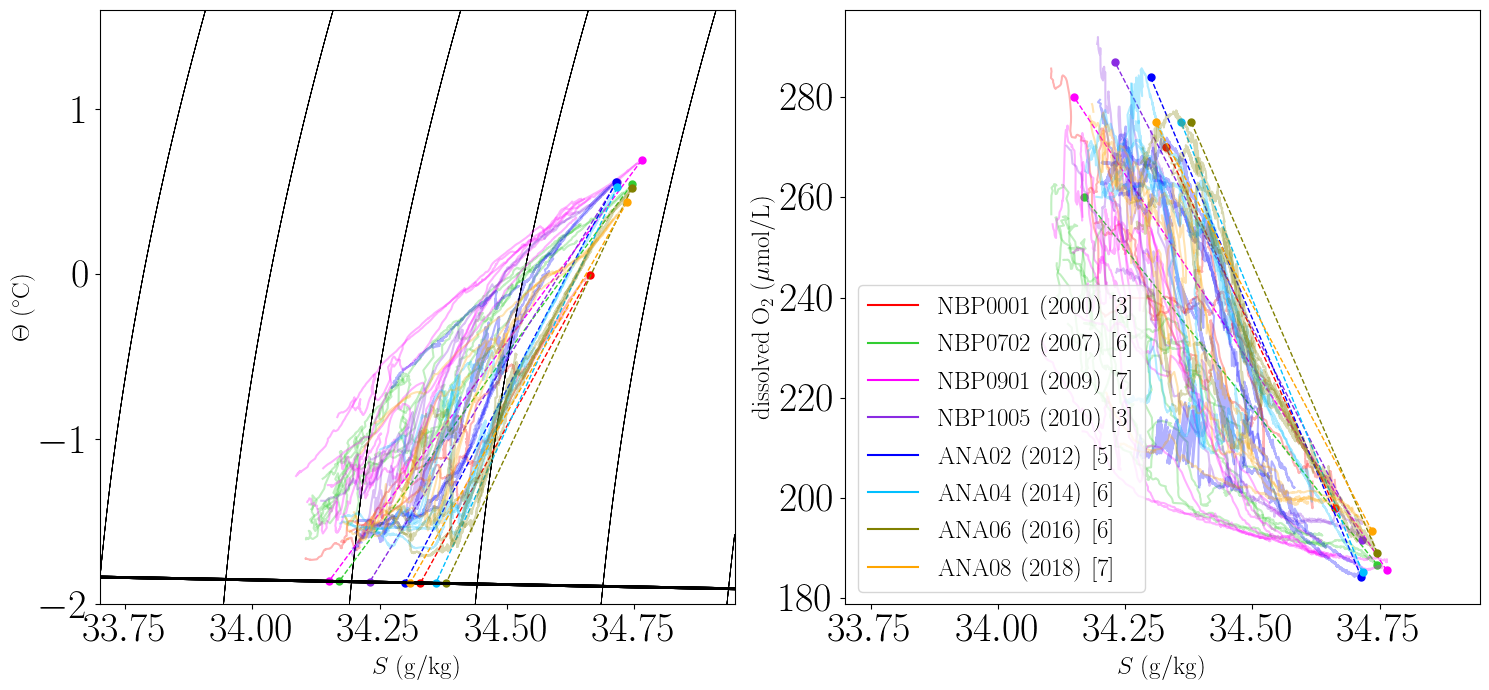

In [27]:
trim=0
alpha=0.3

### NOTE: to plot each cruise separately and veiw detail, comment lines with #% at end and uncomment currently commented lines

fig = plt.figure(figsize = (15,7))#%
gs = gridspec.GridSpec(ncols=2, nrows=1)#%
ax,ax1 = (fig.add_subplot(gs[ 0]), fig.add_subplot(gs[1]))#%
    
for n in range(8):
#     fig = plt.figure(figsize = (15,7))
#     gs = gridspec.GridSpec(ncols=2, nrows=1)
#     ax,ax1 = (fig.add_subplot(gs[ 0]), fig.add_subplot(gs[1]))

    cruise_subset = ds.where(ds.cruise == cruises_ordered_ADmcdw[n], drop=True).sel(pressure=slice(200,None))
    plot_ds = cruise_subset

    index = plot_ds.isel(NPROF=0).cruise_index
    color = colors_ordered_ADmcdw[n]
    for i in range(len(plot_ds.NPROF)):
        cruise_nprof = len(plot_ds.where(plot_ds.cruise_index==index, drop=True).NPROF)
        ax.plot(plot_ds.AS.isel(NPROF=i)[trim:],plot_ds.CT.isel(NPROF=i)[trim:], color=color, alpha = alpha)
        ax1.plot(plot_ds.AS.isel(NPROF=i)[trim:],plot_ds.DO.isel(NPROF=i)[trim:], color=color, alpha = alpha,label=plot_ds.isel(NPROF=i).cruise.values+' ('+str(plot_ds.isel(NPROF=i).time.values)[:4]+') ['+str(cruise_nprof)+']')

    Θ_mCDW_i = Θ_mCDW[n]
    S_mCDW_i  = S_mCDW[n]
    DO_mCDW_i  = DO_mCDW[n]
    S_WW_i = S_WW[n]
    Θ_WW_i = Θ_WW[n]
    DO_WW_i = DO_WW[n]

    ax.plot([S_mCDW_i,S_WW_i], [Θ_mCDW_i,Θ_WW_i], color=color, linewidth=1, linestyle='dashed')
    ax1.plot([S_mCDW_i,S_WW_i], [DO_mCDW_i,DO_WW_i], color=color, linewidth=1, linestyle='dashed')
    ax.plot(S_mCDW_i,Θ_mCDW_i, marker='o', color=color, markersize=5)
    ax1.plot(S_mCDW_i,DO_mCDW_i, marker='o', color=color, markersize=5)
    ax.plot(S_WW_i,Θ_WW_i, marker='o', color=color, markersize=5)
    ax1.plot(S_WW_i,DO_WW_i, marker='o', color=color, markersize=5)

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = ax1.legend(by_label.values(), by_label.keys(), fontsize=18)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    Tarray = np.arange(-2,1.7,0.1)
    Sarray = np.arange(33.5,34.95,0.0036)
    Sgrid, Tgrid = np.meshgrid(Sarray, Tarray)
    SIGMA0 = sigma0(Sgrid,Tgrid)
    ax.contour(Sgrid,Tgrid,SIGMA0, levels = [26.8,27,27.2,27.4,27.6,27.8,28], colors='k',linewidths=0.5)
    ax.set_ylabel('$\Theta\; (^\circ\mathrm{C})$', fontsize=18)
    ax.set_xlabel('$S \;(\mathrm{g/kg})$', fontsize=18)
    ax1.set_ylabel(r'$\mathrm{dissolved}\;\mathrm{O}_2 \;(\mu\mathrm{mol/L})$', fontsize=18)
    ax1.set_xlabel('$S \;(\mathrm{g/kg})$', fontsize=18)

    freeze = t_freezing(Sarray,0,0)
    ax.plot(Sarray,freeze, 'k', linewidth=2)
#     ax.set_xlim([33.7,Sgrid.max()])
#     ax1.set_xlim([33.7,Sgrid.max()])
#     fig.tight_layout()
#     plt.show()

ax.set_xlim([33.7,Sgrid.max()])#%
ax1.set_xlim([33.7,Sgrid.max()])#%
fig.tight_layout()#%
plt.show()#%

#### compute water mass volume fractions

In [28]:
ds_ADmcdw = ds.where(ds.deepest_measurement>500,drop=True) #only use profiles likely to sample all watermasses (some more excluded later that do not sample WW)


In [29]:
def watermass_volumes(k, ds):
    cruise = cruises_ordered_ADmcdw[k]
    cruise_subset = ds.where(ds.cruise == cruise, drop=True).sel(pressure=slice(200,None))
    Θ_mCDW_cruise = Θ_mCDW[k]
    S_mCDW_cruise = S_mCDW[k]
    DO_mCDW_cruise = DO_mCDW[k]
    S_WW_cruise = S_WW[k]
    Θ_WW_cruise = Θ_WW[k]
    DO_WW_cruise = DO_WW[k]
    S_MW_cruise = 0
    Θ_MW_cruise = -95
    DO_MW_cruise = 1065

    S_obs = cruise_subset.AS
    Θ_obs = cruise_subset.CT
    DO_obs = cruise_subset.DO
    pressure = cruise_subset.pressure

    # γ1 = Θ, γ2 = S
    V_MW1 = ((S_obs - S_mCDW_cruise)-(Θ_obs-Θ_mCDW_cruise)*((S_WW_cruise-S_mCDW_cruise)/(Θ_WW_cruise-Θ_mCDW_cruise)))/((S_MW_cruise - S_mCDW_cruise)-(Θ_MW_cruise-Θ_mCDW_cruise)*((S_WW_cruise-S_mCDW_cruise)/(Θ_WW_cruise-Θ_mCDW_cruise)))
    V_WW1 = ((Θ_obs-Θ_mCDW_cruise)-(Θ_MW_cruise-Θ_mCDW_cruise)*V_MW1)/(Θ_WW_cruise-Θ_mCDW_cruise)
    V_mCDW1 = ((Θ_obs-Θ_WW_cruise)-(Θ_MW_cruise-Θ_WW_cruise)*V_MW1)/(Θ_mCDW_cruise-Θ_WW_cruise)
    # γ1 = Θ, γ2 = DO
    V_MW2 = ((DO_obs - DO_mCDW_cruise)-(Θ_obs-Θ_mCDW_cruise)*((DO_WW_cruise-DO_mCDW_cruise)/(Θ_WW_cruise-Θ_mCDW_cruise)))/((DO_MW_cruise - DO_mCDW_cruise)-(Θ_MW_cruise-Θ_mCDW_cruise)*((DO_WW_cruise-DO_mCDW_cruise)/(Θ_WW_cruise-Θ_mCDW_cruise)))
    V_WW2 = ((Θ_obs-Θ_mCDW_cruise)-(Θ_MW_cruise-Θ_mCDW_cruise)*V_MW1)/(Θ_WW_cruise-Θ_mCDW_cruise)
    V_mCDW2 = ((Θ_obs-Θ_WW_cruise)-(Θ_MW_cruise-Θ_WW_cruise)*V_MW1)/(Θ_mCDW_cruise-Θ_WW_cruise)
    # γ1 = S, γ2 = DO
    V_MW3 = ((DO_obs - DO_mCDW_cruise)-(S_obs-S_mCDW_cruise)*((DO_WW_cruise-DO_mCDW_cruise)/(S_WW_cruise-S_mCDW_cruise)))/((DO_MW_cruise - DO_mCDW_cruise)-(S_MW_cruise-S_mCDW_cruise)*((DO_WW_cruise-DO_mCDW_cruise)/(S_WW_cruise-S_mCDW_cruise)))
    V_WW3 = ((S_obs-S_mCDW_cruise)-(S_MW_cruise-S_mCDW_cruise)*V_MW1)/(S_WW_cruise-S_mCDW_cruise)
    V_mCDW3 = ((S_obs-S_WW_cruise)-(S_MW_cruise-S_WW_cruise)*V_MW1)/(S_mCDW_cruise-S_WW_cruise)

    
    V_MW = np.mean((V_MW1,V_MW2,V_MW3),axis=0)
    V_WW = np.mean((V_WW1,V_WW2,V_WW3),axis=0)
    V_mCDW = np.mean((V_mCDW1,V_mCDW2,V_mCDW3),axis=0)

    V_MW = xr.zeros_like(S_obs)+V_MW
    V_WW = xr.zeros_like(S_obs)+V_WW
    V_mCDW = xr.zeros_like(S_obs)+V_mCDW
    
    return V_MW,V_WW,V_mCDW

In [30]:
V_MW_2000,V_WW_2000,V_mCDW_2000 = watermass_volumes(0,ds_ADmcdw)
V_MW_2007,V_WW_2007,V_mCDW_2007 = watermass_volumes(1,ds_ADmcdw)
V_MW_2009,V_WW_2009,V_mCDW_2009 = watermass_volumes(2,ds_ADmcdw)
V_MW_2010,V_WW_2010,V_mCDW_2010 = watermass_volumes(3,ds_ADmcdw)
V_MW_2012,V_WW_2012,V_mCDW_2012 = watermass_volumes(4,ds_ADmcdw)
V_MW_2014,V_WW_2014,V_mCDW_2014 = watermass_volumes(5,ds_ADmcdw)
V_MW_2016,V_WW_2016,V_mCDW_2016 = watermass_volumes(6,ds_ADmcdw)
V_MW_2018,V_WW_2018,V_mCDW_2018 = watermass_volumes(7,ds_ADmcdw)
V_MW = xr.concat((V_MW_2000,V_MW_2007, V_MW_2009,V_MW_2010,V_MW_2012,V_MW_2014,V_MW_2016,V_MW_2018), dim='NPROF')
V_WW = xr.concat((V_WW_2000,V_WW_2007, V_WW_2009,V_WW_2010,V_WW_2012,V_WW_2014,V_WW_2016,V_WW_2018), dim='NPROF')
V_mCDW = xr.concat((V_mCDW_2000,V_mCDW_2007, V_mCDW_2009,V_mCDW_2010,V_mCDW_2012,V_mCDW_2014,V_mCDW_2016,V_mCDW_2018), dim='NPROF')



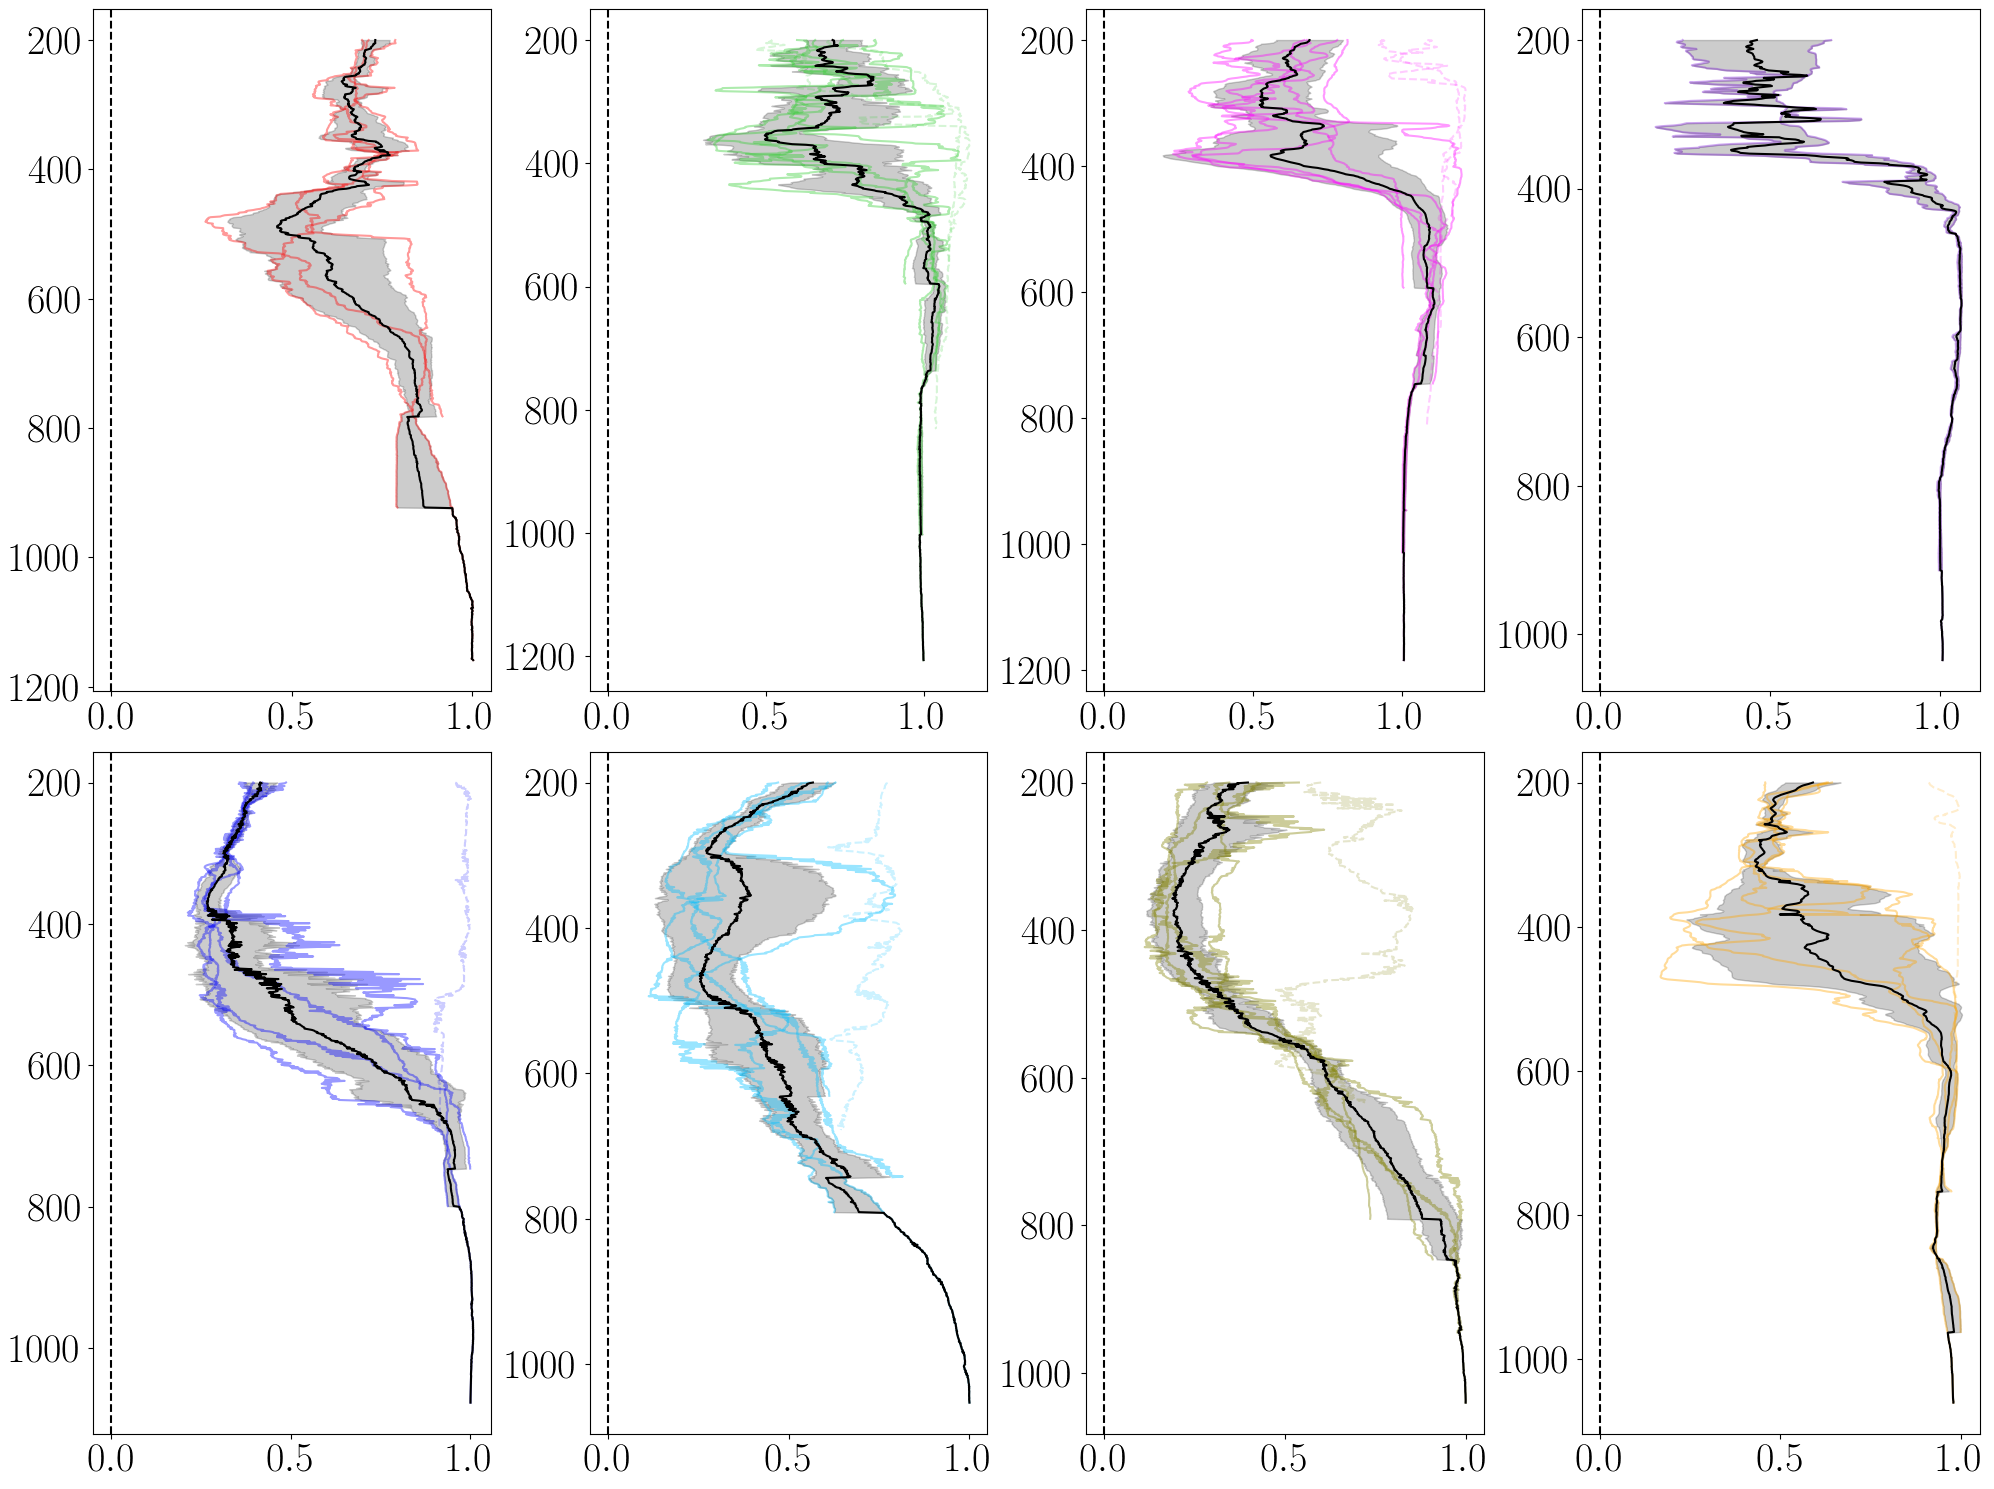

In [31]:
fig, axs = plt.subplots(2,4, figsize=(20,15))

for k in range(len(cruises_ordered_ADmcdw)):
    cruise = cruises_ordered_ADmcdw[k]
    mCDW = V_mCDW.where(V_mCDW.cruise == cruise, drop=True)
    
    if k==0: ax = axs[0,0]
    elif k==1: ax = axs[0,1]
    elif k==2 :ax = axs[0,2]
    elif k==3: ax = axs[0,3]
    elif k==4: ax = axs[1,0]
    elif k==5: ax = axs[1,1]
    elif k==6: ax = axs[1,2]
    elif k==7: ax = axs[1,3]
        
        
    # some profiles basically don't contain WW, only mCDW and MW and that throws off numbers (essetially getting rid of profiles where WW never goes above 0.5)
    if k == 1 or k==2:
        ax.plot(mCDW[0:2,:].T, mCDW.pressure, color=colors_ordered_ADmcdw[k], linestyle='dashed',alpha=0.2)
        mCDW[0:2,:] = np.nan;
    elif k == 4:
        ax.plot(mCDW[3,:].T, mCDW.pressure, color=colors_ordered_ADmcdw[k], linestyle='dashed',alpha=0.2)
        mCDW[3,:] = np.nan;
    elif k == 5 or k==6:
        ax.plot(mCDW[4,:].T, mCDW.pressure, color=colors_ordered_ADmcdw[k], linestyle='dashed',alpha=0.2)
        mCDW[4,:] = np.nan;
    elif k == 7:
        ax.plot(mCDW[0,:].T, mCDW.pressure, color=colors_ordered_ADmcdw[k], linestyle='dashed',alpha=0.2)
        mCDW[0,:] = np.nan;
        
    ax.plot(mCDW.T, mCDW.pressure, color=colors_ordered_ADmcdw[k],alpha=0.4);ax.invert_yaxis();ax.axvline(0, color='k', linestyle='dashed')
    mean_mCDW = mCDW.mean('NPROF').T
    std_mCDW = mCDW.std('NPROF').T
    ax.plot(mean_mCDW, mean_mCDW.pressure, color='k',alpha=1)
    ax.fill_betweenx(mean_mCDW.pressure,mean_mCDW-std_mCDW,mean_mCDW+std_mCDW, color='k',alpha=0.2 )

fig.tight_layout()
plt.show()

In [32]:
cruises_ordered_ADmcdw = xr.DataArray(cruises_ordered_ADmcdw, coords=[cruises_ordered_ADmcdw], dims='cruise')
V_mCDW_mean = xr.DataArray(np.zeros((len(cruises_ordered_ADmcdw),len(V_mCDW.pressure))), coords=[cruises_ordered_ADmcdw,V_mCDW.pressure])
V_mCDW_min = xr.DataArray(np.zeros((len(cruises_ordered_ADmcdw),len(V_mCDW.pressure))), coords=[cruises_ordered_ADmcdw,V_mCDW.pressure])
V_mCDW_max = xr.DataArray(np.zeros((len(cruises_ordered_ADmcdw),len(V_mCDW.pressure))), coords=[cruises_ordered_ADmcdw,V_mCDW.pressure])
max_deepest = xr.DataArray(np.zeros(len(cruises_ordered_ADmcdw)), coords=[cruises_ordered_ADmcdw], dims={'cruise'})
V_mCDW_mean[:,:] = np.nan
V_mCDW_min[:,:] = np.nan
V_mCDW_max[:,:] = np.nan
for i in range(len(cruises_ordered_ADmcdw)):
    cruise = cruises_ordered_ADmcdw[i]
    mCDW = V_mCDW.where(V_mCDW.cruise == cruise, drop=True)
    # some profiles basically don't contain WW, only mCDW and MW and that throws off numbers (essetially getting rid of profiles where WW never goes above 0.5)
    if i == 1 or i==2:
        mCDW[0:2,:] = np.nan;
    elif i == 4:
        mCDW[3,:] = np.nan;
    elif i == 5 or i==6:
        mCDW[4,:] = np.nan;
    elif i == 7:
        mCDW[0,:] = np.nan;

    max_deepest[i] = mCDW.deepest_measurement.max().values
    V_mCDW_mean[i,:] = mCDW.mean('NPROF')
    sigma = mCDW.std('NPROF')
    V_mCDW_min[i,:] = mCDW.mean('NPROF')-sigma    
    V_mCDW_max[i,:] = mCDW.mean('NPROF')+sigma    
    
AD_mCDW_mean = max_deepest-V_mCDW_mean.sum('pressure')
AD_mCDW_min = max_deepest-V_mCDW_max.sum('pressure')
AD_mCDW_max = max_deepest-V_mCDW_min.sum('pressure') #checked and it's symmetrical
AD_mCDW_error = AD_mCDW_mean-AD_mCDW_min

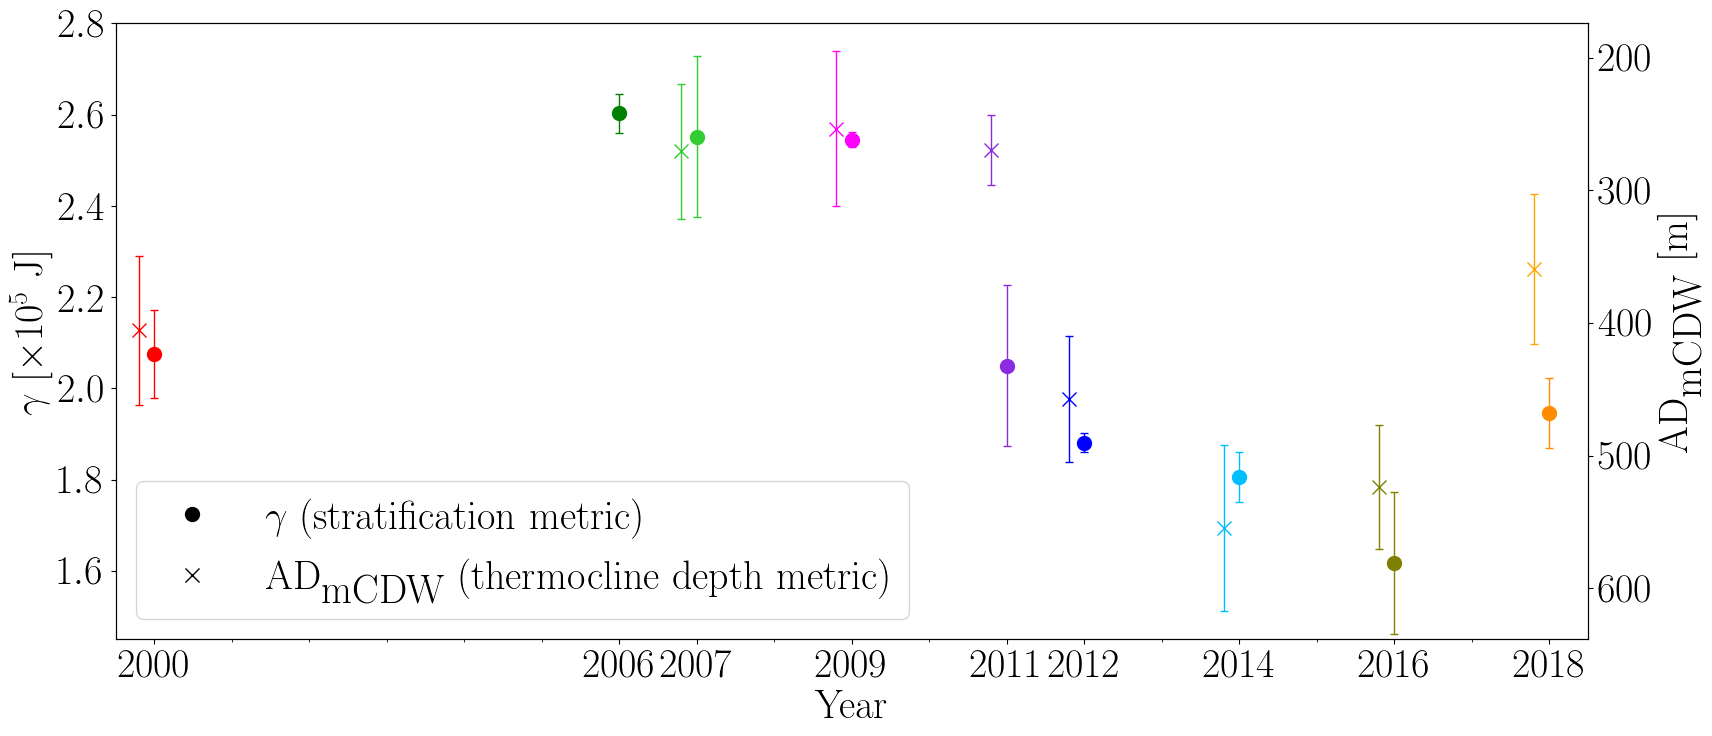

In [33]:
fig = plt.figure(figsize = (19,8))
ax = fig.add_subplot()
for i in range(9):
    ax.errorbar(years_ordered[i], γ_timeseries[i]/1e5, yerr = γ_std_timeseries[i]/1e5, fmt='o', markersize=10,color=colors_ordered[i], capsize=3, elinewidth=1, capthick=1)
ax1=ax.twinx()
for i in range(8):
    ax1.errorbar(years_ordered_ADmcdw[i]-0.2, AD_mCDW_mean[i], yerr = AD_mCDW_error[i], fmt='x', markersize=10,color=colors_ordered_ADmcdw[i], capsize=3, elinewidth=1, capthick=1)

ax1.invert_yaxis()
ax.set_xticks(years_ordered)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel(r'$\gamma$ [$\times 10^5$ J]')
ax1.set_ylabel(r'$\textrm{AD}_\textrm{mCDW}$ [m]')
ln1 = ax.plot(1990, 5, 'ko', markersize=10,linewidth=0, label=r'$\gamma$ (stratification metric)')
ln2 = ax1.plot(1990, 200, 'kx',markersize=10, label=r'$\textrm{AD}_\textrm{mCDW}$ (thermocline depth metric)')
lns=ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3, fontsize=29)
ax.set_xlim([1999.5,2018.5])
ax.set_ylim([1.45,2.8])
ax1.set_xlim([1999.5,2018.5])
# plt.savefig('Figure1_d.png')

plt.show()

## Alterative thermocline depth metric

We also tried deriving the thermocline as an isotherm from the smoothed density binned mean temperature profiles in Figure 1 (b). 

Unfortunately this is sensitive to the choice of isotherm. 0C was an obvious choice but doesn't visually match the data. Based on the warm period years with much sharper thermoclines we choose -0.4C

The pattern is much the same as the Kim et al 2021 metric above so we decided to show the former in our manuscript, in part becuase the density of mCDW is more consistent than the temperature. 

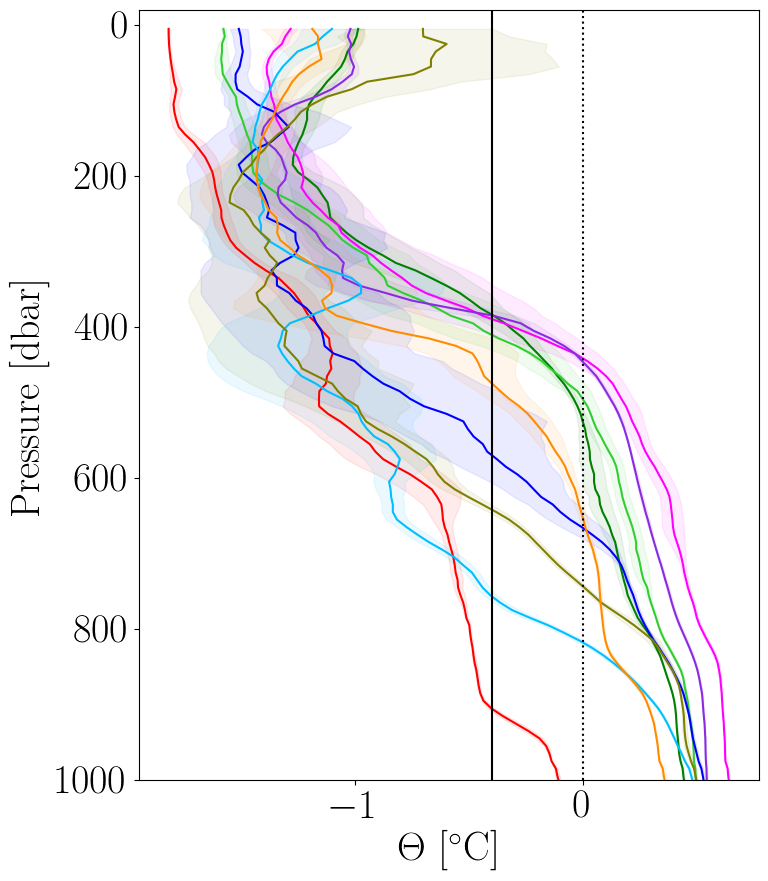

In [34]:
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot()

for i in range(0,len(CT_mean.cruise_index)):
    index=cruise_index[i]
    color = colors_ordered[i]
    cruise = cruises_ordered[i]
    year = str(years_ordered[i])
    profs = str(len(CT.where(CT.cruise_index==index,drop=True).NPROF))
    smoothed_CT = CT_mean.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    smoothed_CT_std = CT_std.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    smoothed_AS = AS_mean.sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    ax.plot(smoothed_CT.T, CT_mean.pressure_midpoint, color=color, linewidth=1.5, label=cruise+' ('+year+') ['+profs+']')
    ax.fill_betweenx(CT_mean.pressure_midpoint,smoothed_CT-smoothed_CT_std,smoothed_CT+smoothed_CT_std, color=color,alpha=0.08 )
ax.axvline(-0.4, color='k')
ax.axvline(0, color='k', linestyle=':')
# ax.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize=29)  
ax.set_ylim([1000,-20]);
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('$\Theta$ [$^\circ$C]')
# plt.savefig('Figure1_bc.png')
plt.show()

In [35]:
isotherm0C =np.zeros((len(CT_mean.cruise_index)))
lower = np.zeros((len(CT_mean.cruise_index)))
upper = np.zeros((len(CT_mean.cruise_index)))
therm = -0.4

for i in range(len(CT_mean.cruise_index)):
    index=cruise_index[i]
    color = colors_ordered[i]
    cruise = cruises_ordered[i]
    year = str(years_ordered[i])
    profs = str(len(CT.where(CT.cruise_index==index,drop=True).NPROF))
    smoothed_CT = CT_mean[:,20:].sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()
    smoothed_CT_std = CT_std[:,20:].sel(cruise_index=index).rolling(pressure_midpoint=5,center=True, min_periods=1).mean()

    isotherm0C[i] = np.interp(therm,smoothed_CT,smoothed_CT.pressure_midpoint)
    lower[i] = np.interp(therm,(smoothed_CT-smoothed_CT_std),smoothed_CT.pressure_midpoint)
    upper[i] = np.interp(therm,(smoothed_CT+smoothed_CT_std),smoothed_CT.pressure_midpoint)



In [36]:
lower_err = lower-isotherm0C
upper_err = isotherm0C-upper


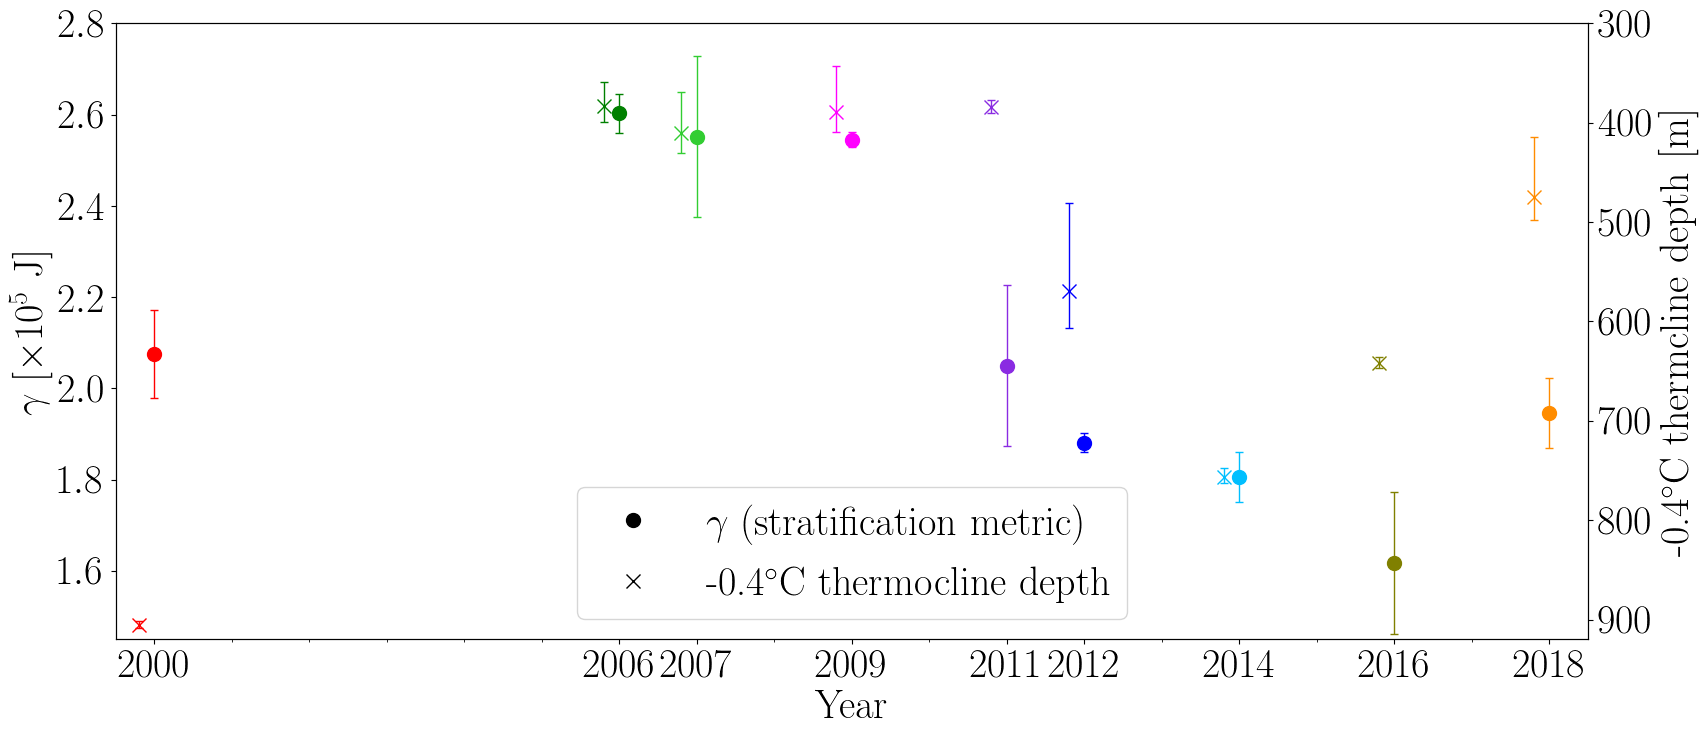

In [37]:
fig = plt.figure(figsize = (19,8))
ax = fig.add_subplot()
for i in range(9):
    ax.errorbar(years_ordered[i], γ_timeseries[i]/1e5, yerr = γ_std_timeseries[i]/1e5, fmt='o', markersize=10,color=colors_ordered[i], capsize=3, elinewidth=1, capthick=1)
ax1=ax.twinx()
for i in range(9):
    ax1.errorbar(years_ordered[i]-0.2, isotherm0C[i], yerr = np.expand_dims(np.array([upper_err[i],lower_err[i]]),1), fmt='x', markersize=10,color=colors_ordered[i], capsize=3, elinewidth=1, capthick=1)

ax1.invert_yaxis()
ax.set_xticks(years_ordered)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel(r'$\gamma$ [$\times 10^5$ J]')
ax1.set_ylabel(r'-0.4$^\circ$C thermcline depth [m]')
ln1 = ax.plot(1990, 5, 'ko', markersize=10,linewidth=0, label=r'$\gamma$ (stratification metric)')
ln2 = ax1.plot(1990, 200, 'kx',markersize=10, label=r'-0.4$^\circ$C thermocline depth')
lns=ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=8, fontsize=29)
ax.set_xlim([1999.5,2018.5])
ax.set_ylim([1.45,2.8])
ax1.set_xlim([1999.5,2018.5])
ax1.set_ylim([920,300])
# plt.savefig('Figure1_d.png')

plt.show()